In [1]:
from sklearn import model_selection
from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
import os
import torch
import numpy as np
import pandas as pd
from MicroBiome import MicroBiomeDataSet, Trainer, TrainTester, MultiTrainTester
from SNN import FeedForward, SiameseDataSet, SiameseModel
import seaborn as sns
import numpy as np
import random

# Ignore warning messages
if True:
    import warnings
    warnings.filterwarnings('ignore')

# Load Data

In [2]:
iris = datasets.load_iris()
X = iris.data 
y = iris.target
OneHot = OneHotEncoder(sparse=False)
y = OneHot.fit_transform(y.reshape((y.shape[0], 1)))

In [3]:
y

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [4]:
y.shape

(150, 3)

In [5]:
np.sum(y, axis=0)

array([50., 50., 50.])

# Define and Train Model

In [6]:
MyFeedForward = FeedForward(4, [3])

In [7]:
MyFeedForward

FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=3, bias=True)
  )
)

In [8]:
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
MySNN = SiameseModel(MyFeedForward, predict_unknown = False, class_min_train=5, 
                     n_example_predict=10, learning_rate=1.0e-3, num_epochs = 5, batch_size = 10)

In [9]:
# list(MySNN.logistic.parameters()) + list(MySNN.model.parameters())

In [10]:
MyTrainer = Trainer(model = MySNN, scale_X = True, use_pca = False, n_components = 3)

In [11]:
MyTrainTester = TrainTester(MyTrainer, metrics.accuracy_score)

In [12]:
n_splits = 5
MyMultiTrainTester = MultiTrainTester(MyTrainTester, n_splits=n_splits)

In [13]:
MyMultiTrainTester.train(X, y)

Running for split 1 of 5
Training Encoder
#########################################
Epoch 1 of 5
__Training__
2021-03-06 22:52:41
MEAN LOSS: 0.6409749526619911
__Validation__
2021-03-06 22:52:43
MEAN LOSS: 0.6396889467694328
#########################################
Epoch 2 of 5
__Training__
2021-03-06 22:52:43
MEAN LOSS: 0.6369562120556831
__Validation__
2021-03-06 22:52:45
MEAN LOSS: 0.6391701352263656
#########################################
Epoch 3 of 5
__Training__
2021-03-06 22:52:45
MEAN LOSS: 0.6367416906833648
__Validation__
2021-03-06 22:52:47
MEAN LOSS: 0.6390122026070939
#########################################
Epoch 4 of 5
__Training__
2021-03-06 22:52:47
MEAN LOSS: 0.6366598477125168
__Validation__
2021-03-06 22:52:50
MEAN LOSS: 0.638951600295375
#########################################
Epoch 5 of 5
__Training__
2021-03-06 22:52:50
MEAN LOSS: 0.6366178705334663
__Validation__
2021-03-06 22:52:52
MEAN LOSS: 0.6389254035443256
#########################################
Fi

In [14]:
scores_df = pd.DataFrame({'score': MyMultiTrainTester.train_scores, 'stage' : np.repeat('train', n_splits)})
scores_df = scores_df.append(pd.DataFrame({'score': MyMultiTrainTester.test_scores, 'stage' : np.repeat('test', n_splits)}))
scores_df

,score,stage
0,0.900000,train
1,0.758333,train
2,0.908333,train
3,0.816667,train
4,0.700000,train
0,1.000000,test
1,0.733333,test
2,0.900000,test
3,0.933333,test
4,0.766667,test


<AxesSubplot:xlabel='stage', ylabel='score'>

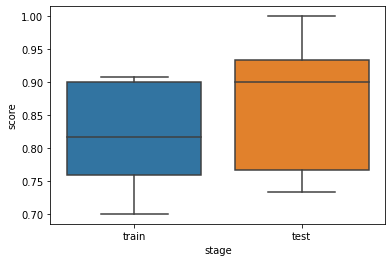

In [15]:
sns.boxplot(data = scores_df, x = 'stage', y = 'score')

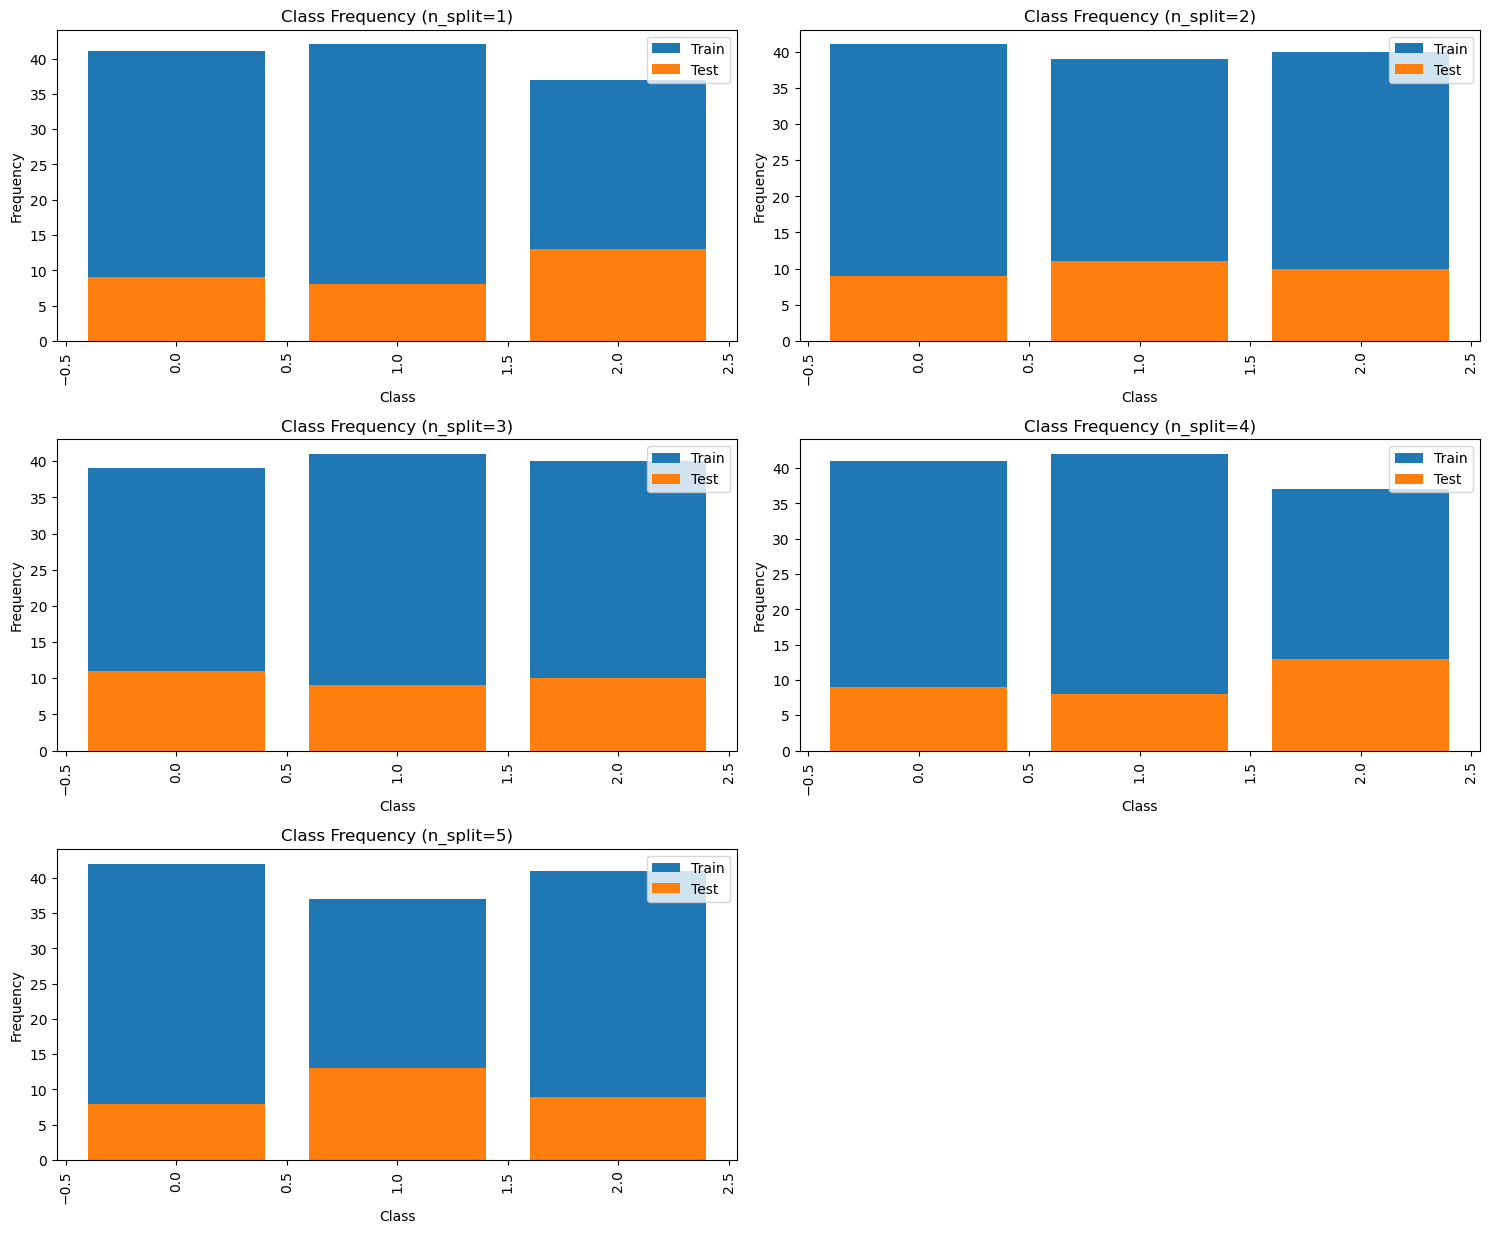

In [16]:
MyMultiTrainTester.plot_class_freq(normalize=True)

In [17]:
Trainer0 = MyMultiTrainTester.TrainerList[0]

In [18]:
y_pred = Trainer0.predict(X)

In [19]:
y_pred

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

In [20]:
y_pred_proba = Trainer0.predict_proba(X)

In [21]:
y_pred

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0

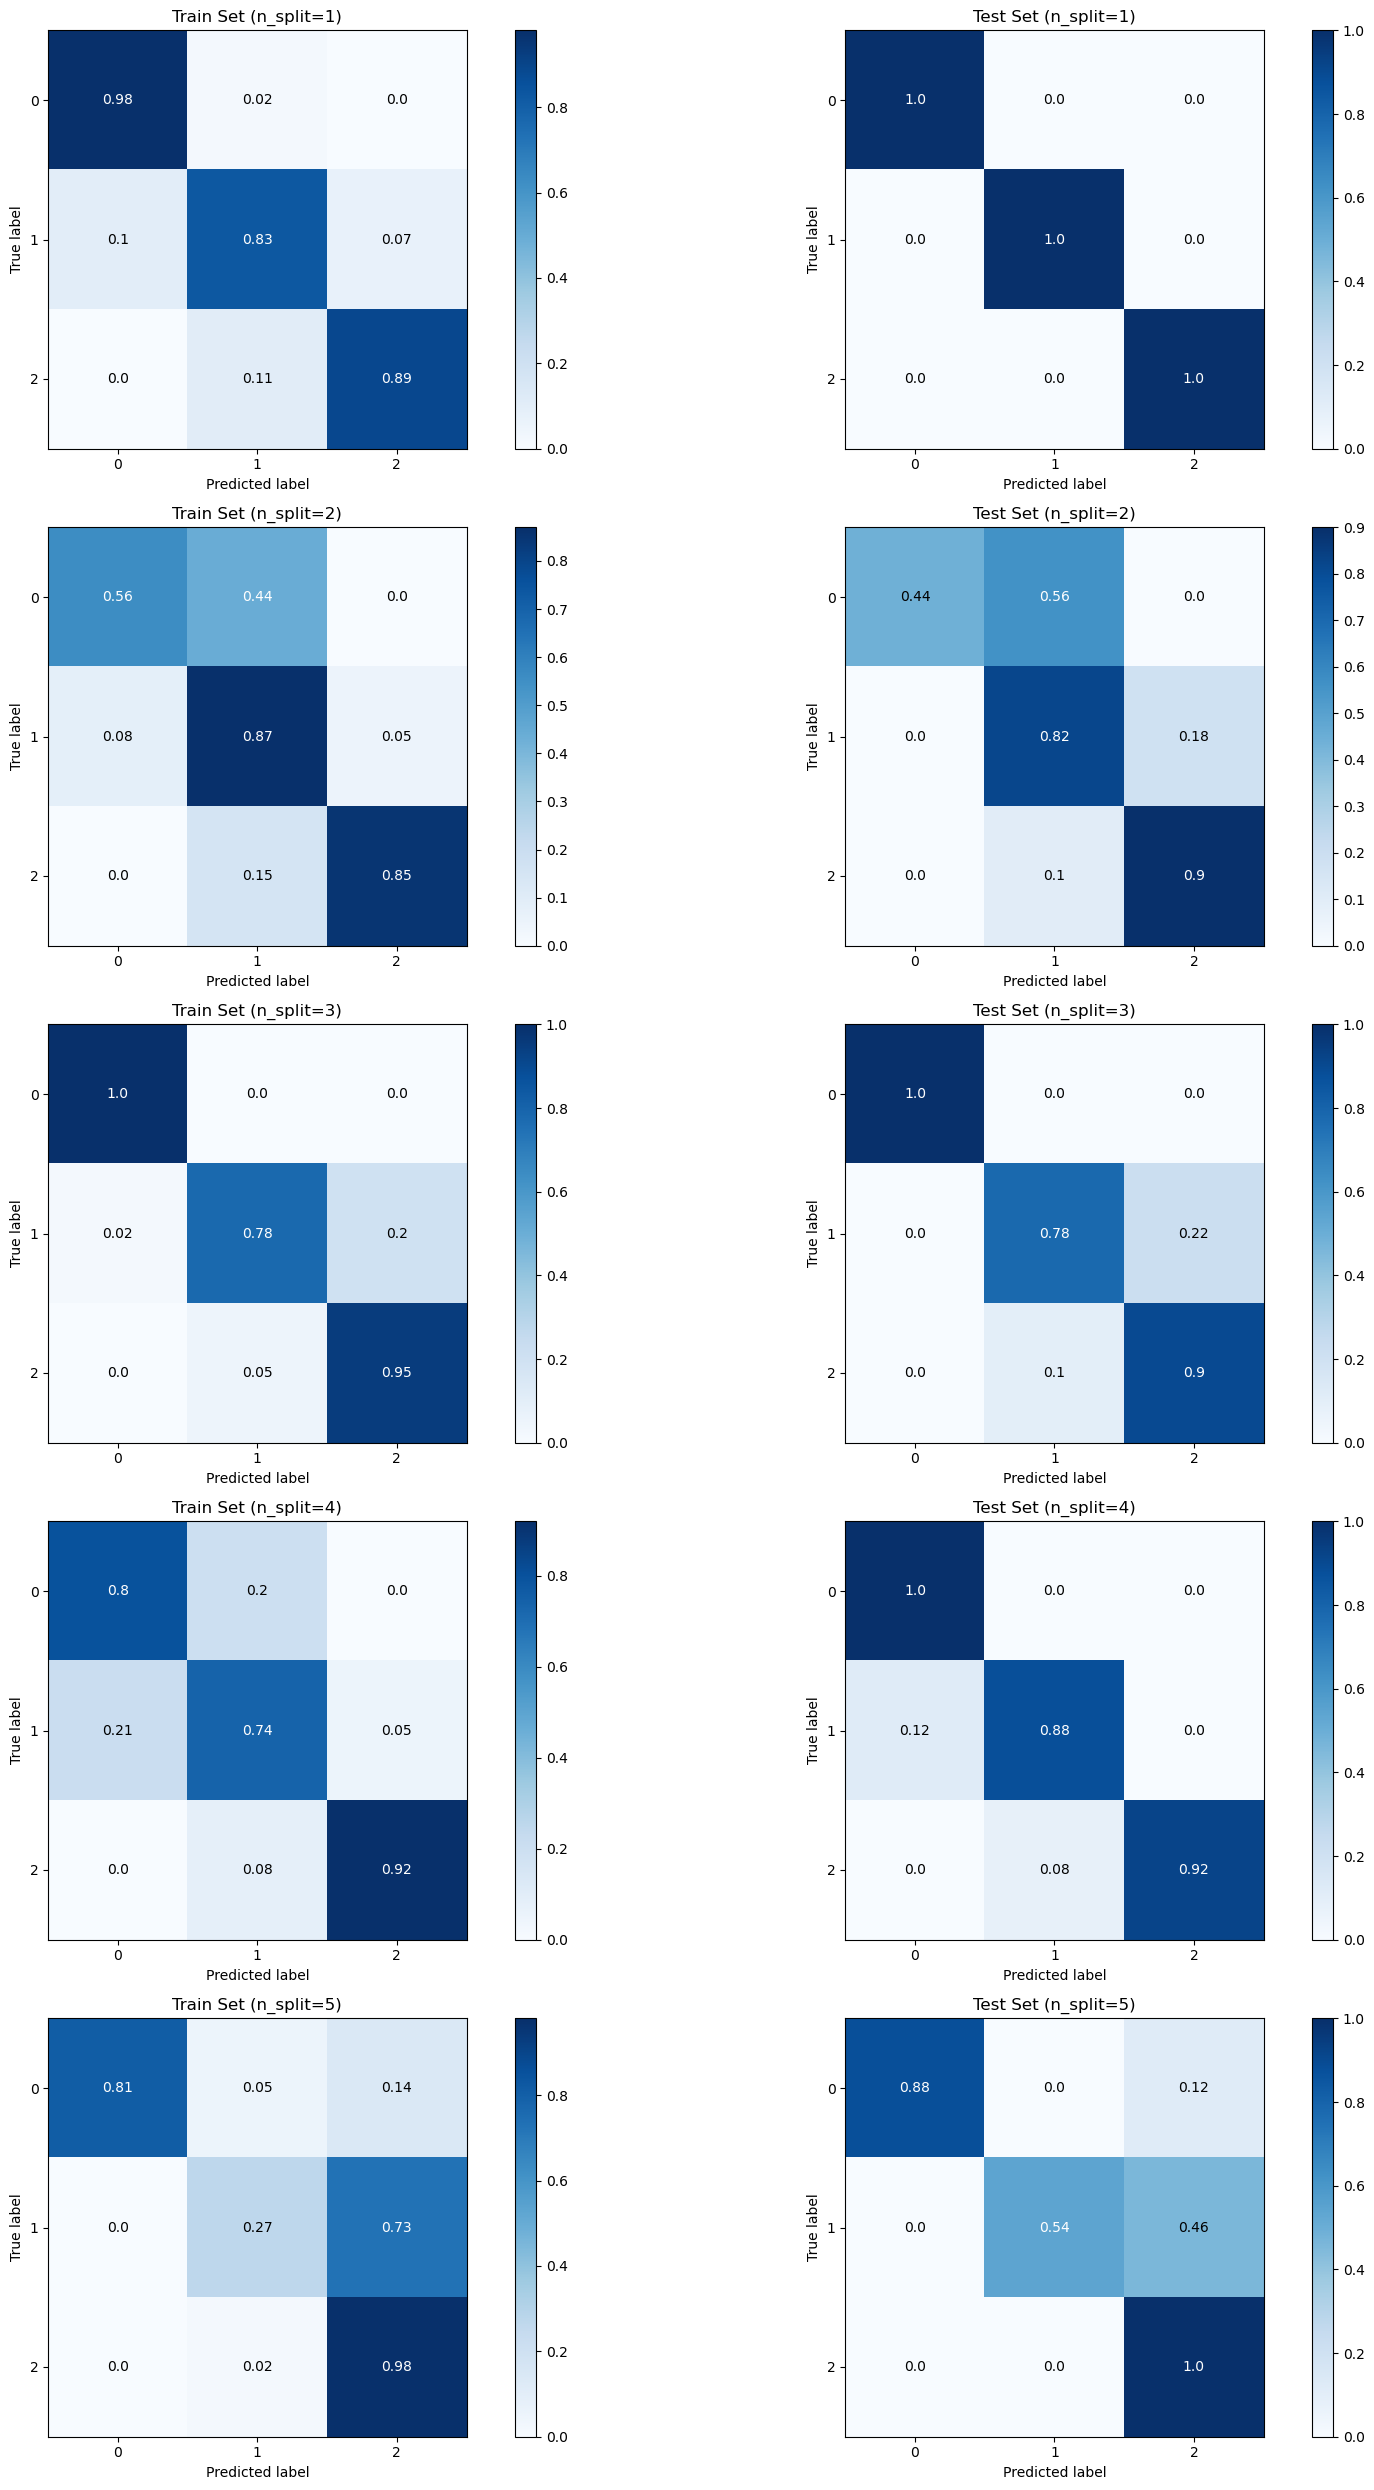

In [22]:
MyMultiTrainTester.plot_confusion(normalize=True)

In [23]:
MyMultiTrainTester.y_train_pred

[array([0, 2, 1, 0, 2, 2, 1, 1, 2, 1, 0, 2, 0, 0, 0, 1, 1, 0, 2, 0, 2, 1,
        1, 0, 0, 0, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 1, 2, 2, 0, 2,
        1, 2, 2, 0, 2, 2, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 0, 2, 2, 0, 0, 2,
        2, 2, 1, 0, 0, 0, 2, 2, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 2, 1, 1, 0, 0, 2, 0, 1, 0, 2, 2, 0,
        1, 1, 1, 1, 0, 2, 0, 1, 2, 2]),
 array([1, 1, 1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 2, 2, 1, 0, 1, 0, 2,
        2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 2,
        0, 1, 1, 2, 1, 2, 2, 1, 0, 0, 1, 0, 1, 1, 2, 1, 1, 0, 0, 1, 1, 2,
        2, 1, 1, 1, 2, 0, 0, 1, 0, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
        1, 0, 0, 1, 2, 2, 1, 1, 2, 2, 2, 0, 0, 1, 2, 1, 0, 0, 2, 2, 2, 2,
        0, 1, 1, 2, 1, 1, 1, 2, 0, 1]),
 array([1, 1, 0, 0, 2, 0, 2, 2, 1, 0, 2, 1, 2, 2, 1, 0, 2, 1, 2, 1, 0, 2,
        1, 2, 2, 0, 2, 2, 0, 1, 1, 2, 0, 1, 0, 2, 2, 2, 2, 0, 0, 2, 0, 0,
        0, 2, 1, 1, 1, 0, 1, 1, 